## LH and SH Flux Calculation
Sanity check that latent and sensible heat are computed as expected with output diagnostics.

The last plot shows that the fractional error is very small.

In [1]:
import sys
import os

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure, partial_pressure_from_sphum
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v, g
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity, opd_lw_gray
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import optimize, ndimage
import cftime
import calendar
from datetime import timedelta
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [3]:
exp_dir = 'rossbypalooza/depth=20/all_nh/lat_10/no_wishe/'
exp_name = 'base_col'
namelist = isca_tools.load_namelist(exp_dir+exp_name)
try:
    p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press']/100
except KeyError:
    p_surface_approx = namelist['column_nml']['reference_sea_level_press']/100
w_atm_const = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['w_atm_const']
drag_const = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['drag_const']

sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

ds = isca_tools.load_dataset(exp_dir + exp_name, decode_times=True).sel(pfull=np.inf, method='nearest').load()

In [4]:
def get_latent_heat(sphum_a, sphum_surf, wind_speed, drag_coef, rho):
    return L_v * drag_coef * rho * wind_speed * (sphum_surf - sphum_a)

def get_sensible_heat(temp_surf, temp_a, rho, wind_speed, drag_coef, sigma=sigma_near_surf):
    temp_diseqb = temp_surf - temp_a
    return c_p * drag_coef * rho * wind_speed * (temp_surf * (1 - sigma ** (-kappa)) + temp_diseqb * sigma ** (-kappa))

In [5]:
print_ds_var_list(ds)

pk: vertical coordinate pressure values
height: geopotential height at full model levels
temp: temperature
ps: surface pressure
sphum: specific humidity
olr: outgoing longwave radiation
swdn_toa: SW flux down at TOA
swdn_sfc: Absorbed SW at surface
lwdn_sfc: LW flux down at surface
lwup_sfc: LW flux up at surface
flux_t: sensible heat flux up at surface
flux_lhe: latent heat flux up at surface
t_surf: surface temperature
precipitation: Precipitation from resolved, parameterised and snow
cape: Convective Available Potential Energy
cin: Convective Inhibition
w_atm: Lowest level wind speed
drag_q: Moisture drag coefficient
rho: Air density at lowest level
q_atm: Lowest level specific humidity
q_surf: Surface specific humidity
average_T1: Start time for average period
average_T2: End time for average period
average_DT: Length of average period
time_bounds: time axis boundaries


In [15]:
ds.w_atm.isel(lon=0).max()

<xarray.DataArray 'w_atm' ()> Size: 8B
array(10.00041199)
Coordinates:
    lon      float64 8B 0.0
    pfull    float64 8B 994.9

In [6]:
flux_lhe_calc = get_latent_heat(ds.q_atm, ds.q_surf, w_atm_const, drag_const, ds.rho)
flux_t_calc = get_sensible_heat(ds.t_surf, ds.temp, ds.rho, w_atm_const, drag_const)

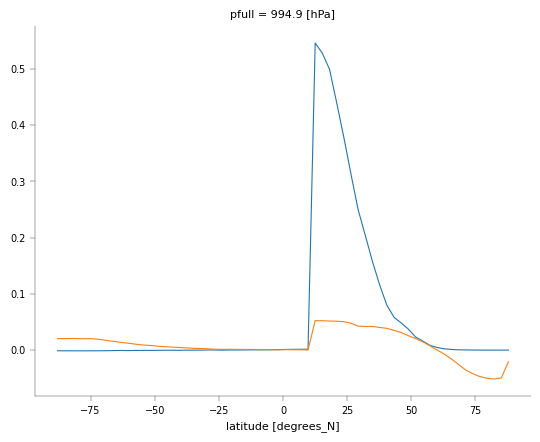

In [20]:
(flux_lhe_calc-ds.flux_lhe).median(dim=['lon', 'time']).plot()
(flux_t_calc-ds.flux_t).median(dim=['lon', 'time']).plot()

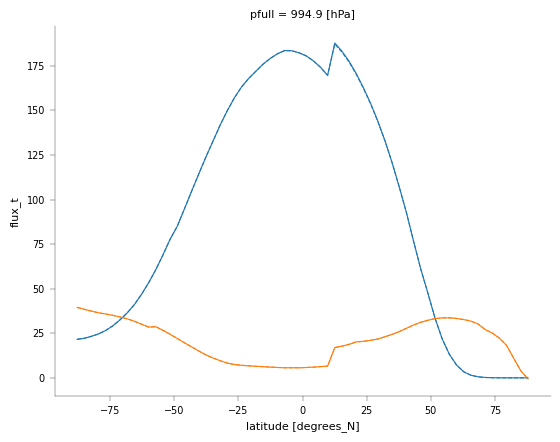

In [25]:
(flux_lhe_calc).median(dim=['lon', 'time']).plot()
ds.flux_lhe.median(dim=['lon', 'time']).plot(color='C0', linestyle='--')
(flux_t_calc).median(dim=['lon', 'time']).plot()
ds.flux_t.median(dim=['lon', 'time']).plot(color='C1', linestyle='--')

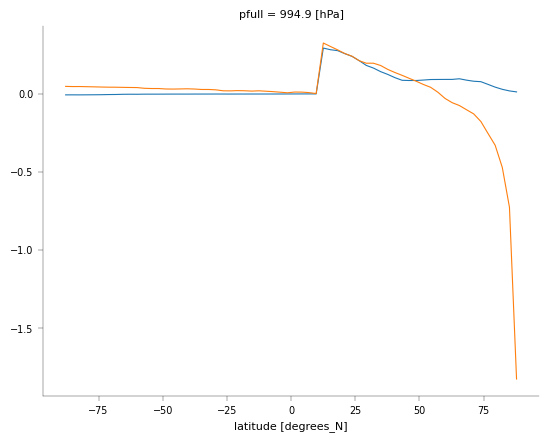

In [9]:
(100*(flux_lhe_calc-ds.flux_lhe) / ds.flux_lhe).median(dim=['lon', 'time']).plot()
(100*(flux_t_calc-ds.flux_t)/ds.flux_t).median(dim=['lon', 'time']).plot()